# Web Scrapping

## Scrapping for Mercado Libre Colombia

Web scraping for the MercadoLibre platform, with the aim of obtaining information to answer the following questions:

- How does the average price of specific products vary among different sellers within MercadoLibre?
- Which features (free shipping, interest-free installments, Full) are most frequently associated with top-ranked or best-selling products?
- What topics or issues (e.g., quality, shipping, description) are most frequently mentioned in negative reviews?
- How does the average response time in the public "Questions and Answers" section vary among sellers with different reputations?
- How complete is the information provided in the listings of top sellers compared to those with lower reputations?

In [16]:
# imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

In [17]:
# Function to build URLs with pagination

def get_pagination_urls(product_name, num_pages=5):
    urls = []
    formatted_product = product_name.replace(' ', '-')
    
    base_url = f"https://listado.mercadolibre.com.co/{formatted_product}"
    urls.append(base_url)
    
    for page in range(2, num_pages + 1):
        from_item = (page - 1) * 50 + 1
        pagination_url = f"https://listado.mercadolibre.com.co/{formatted_product}_Desde_{from_item}_NoIndex_True"
        urls.append(pagination_url)
    
    return urls

In [18]:
# Generate URLs for multiple pages

product = input("Which product do you want to search for? ")
product_name = product.replace(' ', '_')
# Define how many pages to scrape
num_pages = 5  # You can adjust this as needed

# Get list of URLs for all pages
urls = get_pagination_urls(product, num_pages)

print(f"{len(urls)} pages will be scraped:")
for i, url in enumerate(urls, 1):
    print(f"Page {i}: {url}")

5 pages will be scraped:
Page 1: https://listado.mercadolibre.com.co/carpinteria
Page 2: https://listado.mercadolibre.com.co/carpinteria_Desde_51_NoIndex_True
Page 3: https://listado.mercadolibre.com.co/carpinteria_Desde_101_NoIndex_True
Page 4: https://listado.mercadolibre.com.co/carpinteria_Desde_151_NoIndex_True
Page 5: https://listado.mercadolibre.com.co/carpinteria_Desde_201_NoIndex_True


In [19]:
# Scraping using requests and BeautifulSoup

data = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"  
}

for page_num, url in enumerate(urls, 1):
    print(f"Procesando página {page_num} de {len(urls)}: {url}")
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    products = soup.select(".ui-search-layout > li")
    print(f"  Se encontraron {len(products)} productos")

    for i, product in enumerate(products):
        # Extract title
        title_el = product.select_one("h3")
        title = title_el.get_text(strip=True) if title_el else ""

        # Extract price
        price_el = product.select_one(".andes-money-amount")
        price = price_el.get_text(strip=True) if price_el else ""

        # Extract link
        link_el = product.select_one("h3 a, .poly-component__title-wrapper > a")
        link = link_el["href"] if link_el else ""

        # Extract shipping information
        shipping = ""
        sd_el = product.select_one(".poly-shipping--next_day") or product.select_one(".poly-component__shipping")
        if sd_el:
            shipping = sd_el.get_text(strip=True)

        # Extract promotions
        promo_el = product.select_one(".poly-component__ads-promotions")
        promotion = promo_el.get_text(strip=True) if promo_el else ""

        # Extract FULL label
        full_el = product.select_one(".poly-component__shipped-from > svg")
        full = full_el.get("aria-label", "") if full_el else ""

        # Extract discount if available
        discount = ""
        disc_el = product.select_one(".ui-search-price__discount") or product.select_one(".andes-discount-badge")
        if disc_el:
            discount = disc_el.get_text(strip=True)

        # Initialize detail fields
        seller, comments_count, summary_text, reviews = "", "", "", []
        avg_rating, total_ratings = "", ""
        if link:
            try:
                prod_resp = requests.get(link, headers=headers)
                prod_soup = BeautifulSoup(prod_resp.text, "html.parser")
                # Seller info
                seller_el = prod_soup.select_one(".ui-seller-data-header__title") or prod_soup.select_one("h2")
                if seller_el:
                    seller = seller_el.get_text(strip=True).replace("Vendido por ", "")

                # Overall rating and count
                rating_sec = prod_soup.select_one(".ui-review-capability__rating")
                if rating_sec:
                    avg_el = rating_sec.select_one(".ui-review-capability__rating__average")
                    avg_rating = avg_el.get_text(strip=True) if avg_el else ""
                    label_el = rating_sec.select_one(".ui-review-capability__rating__label")
                    total_ratings = label_el.get_text(strip=True) if label_el else ""

                # Reviews summary and count
                section = prod_soup.select_one(".ui-review-capability-filter__comments")
                if section:
                    count_el = section.select_one(".total-opinion")
                    comments_count = count_el.get_text(strip=True) if count_el else ""
                    sum_el = section.select_one(".ui-review-capability__summary__plain_text__summary_container p")
                    summary_text = sum_el.get_text(strip=True) if sum_el else ""
                    # Individual comments
                    for cm in section.select(".ui-review-capability-comments__comment"):
                        rate_txt = cm.select_one(".ui-review-capability-comments__comment__rating-container .andes-visually-hidden").get_text(strip=True)
                        date = cm.select_one(".ui-review-capability-comments__comment__date").get_text(strip=True)
                        content_el = cm.select_one(".ui-review-capability-comments__comment__content")
                        text = content_el.get_text(strip=True) if content_el else ""
                        likes = cm.select_one(".ui-review-capability-valorizations__button-like__text").get_text(strip=True)
                        reviews.append({"rating": rate_txt, "date": date, "content": text, "likes": likes})
            except Exception:
                pass

        # Build product info dict
        product_info = {
            "title": title,
            "price": price,
            "link": link,
            "shipping": shipping,
            "seller": seller,
            "promotion": promotion,
            "full": full,
            "discount": discount,
            "avg_rating": avg_rating,
            "total_ratings": total_ratings,
            "comments_count": comments_count,
            "summary": summary_text,
            "reviews": reviews,
            "page": page_num
        }

        data.append(product_info)
        print(f"  Producto {i+1}: '{title[:30]}...' procesado")

    print(f"Página {page_num} completada. Total de productos hasta ahora: {len(data)}\n")
    time.sleep(2)

print(f"Proceso finalizado. Se recopilaron datos de {len(data)} productos en total.")


Procesando página 1 de 5: https://listado.mercadolibre.com.co/carpinteria
  Se encontraron 50 productos
  Se encontraron 50 productos
  Producto 1: 'Fresa Copiadora  38 Mm De Cort...' procesado
  Producto 1: 'Fresa Copiadora  38 Mm De Cort...' procesado
  Producto 2: 'Cepillo Para Madera Eléctrico ...' procesado
  Producto 2: 'Cepillo Para Madera Eléctrico ...' procesado
  Producto 3: 'Placa De Inserción De Mesa Par...' procesado
  Producto 3: 'Placa De Inserción De Mesa Par...' procesado
  Producto 4: 'Prensa Rápida Sargento X2 Unid...' procesado
  Producto 4: 'Prensa Rápida Sargento X2 Unid...' procesado
  Producto 5: 'Barra O Brazo De Soporte Teles...' procesado
  Producto 5: 'Barra O Brazo De Soporte Teles...' procesado
  Producto 6: 'Broca Forstner 35mm Con Tope D...' procesado
  Producto 6: 'Broca Forstner 35mm Con Tope D...' procesado
  Producto 7: 'Fresa Copiadora  38 Mm De Cort...' procesado
  Producto 7: 'Fresa Copiadora  38 Mm De Cort...' procesado
  Producto 8: 'Escuadra Ra

In [20]:
# Save results to CSV
import pandas as pd

df = pd.DataFrame(data)
df.to_csv(f"data_{product_name}.csv", index=False)

# Dashboard: Analysis and Visualization

En esta sección cargamos los datos obtenidos y generamos visualizaciones que ayudan a explorar precios, calificaciones, descuentos y reseñas.

In [22]:
# Cargar dataframe desde CSV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset generado
df = pd.read_csv(f"data_{product_name}.csv")

### Gráficas

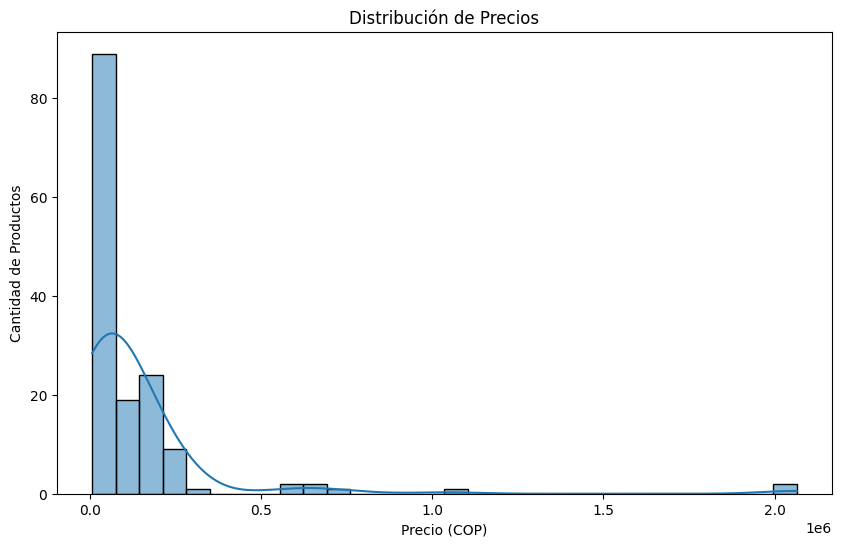

In [23]:
# Histograma de distribución de precios
plt.figure(figsize=(10,6))
# Convertir price a número
df['price_num'] = df['price'].str.replace(r"[^0-9]", "", regex=True).astype(float)
sns.histplot(df['price_num'], bins=30, kde=True)
plt.title('Distribución de Precios')
plt.xlabel('Precio (COP)')
plt.ylabel('Cantidad de Productos')
plt.show()

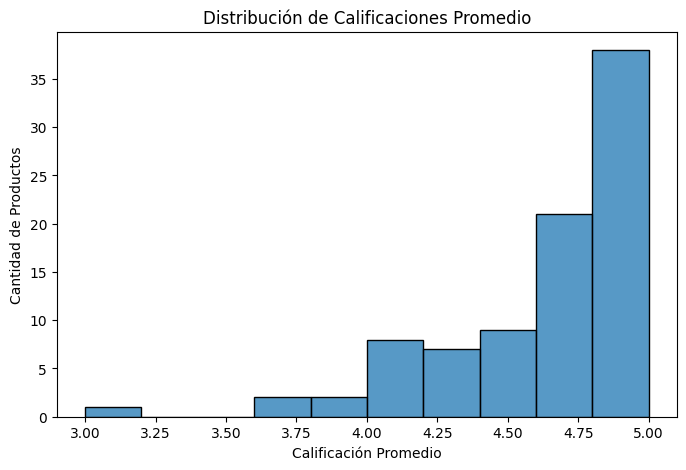

In [24]:
# Distribución de calificaciones promedio
plt.figure(figsize=(8,5))
# Convertir avg_rating a número
df['avg_rating_num'] = pd.to_numeric(df['avg_rating'], errors='coerce')
sns.histplot(df['avg_rating_num'], bins=10, kde=False)
plt.title('Distribución de Calificaciones Promedio')
plt.xlabel('Calificación Promedio')
plt.ylabel('Cantidad de Productos')
plt.show()

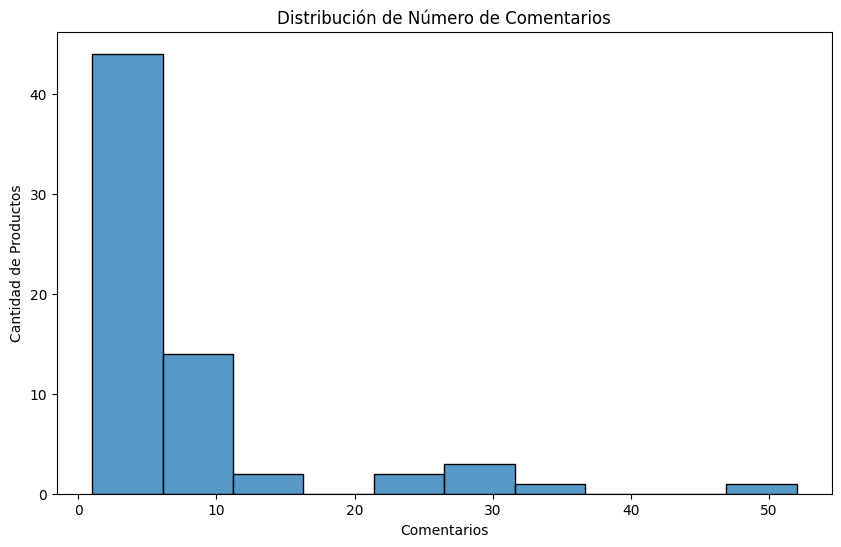

In [27]:
# Análisis de reseñas: número total de comentarios por producto
plt.figure(figsize=(10,6))
df['comments_count_num'] = df['comments_count'].str.extract(r"(\d+)").astype(float)
sns.histplot(df['comments_count_num'], bins=10)
plt.title('Distribución de Número de Comentarios')
plt.xlabel('Comentarios')
plt.ylabel('Cantidad de Productos')
plt.show()